# 1. Import and Install Dependencies

In [1]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib transformers

Note: you may need to restart the kernel to use updated packages.


# 1. Run a simple real-time Mediapipe demo:
    #    - Opens your webcam.
    #    - Processes each frame using Mediapipe's Holistic model.
    #    - Detects and draws face, pose, and hand landmarks in real time.
    #    - Displays the processed video feed in a resizable window.
    #    - Press 'q' to exit the demo.

In [1]:
import cv2
import numpy as np
import os

In [ ]:
import mediapipe as mp
from matplotlib import pyplot as plt
import time
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats
import re
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output, display

In [1]:
# Initialize Mediapipe objects
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(
        image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
        mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    )
    # Draw pose connections
    mp_drawing.draw_landmarks(
        image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    )
    # Draw left hand connections
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
    )
    # Draw right hand connections
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
    )

def extract_keypoints(results):
    """
    Extract keypoints for pose, face, left hand, and right hand from the Mediapipe results.
    Returns:
        A 1D numpy array with a total of 1662 elements:
          - Pose: 33 keypoints × 4 values = 132 elements
          - Face: 468 keypoints × 3 values = 1404 elements
          - Left hand: 21 keypoints × 3 values = 63 elements
          - Right hand: 21 keypoints × 3 values = 63 elements
    """
    # Extract pose keypoints
    pose = np.array([[res.x, res.y, res.z, res.visibility]
                     for res in results.pose_landmarks.landmark]).flatten() \
           if results.pose_landmarks else np.zeros(33*4)

    # Extract face keypoints
    face = np.array([[res.x, res.y, res.z]
                     for res in results.face_landmarks.landmark]).flatten() \
           if results.face_landmarks else np.zeros(468*3)

    # Extract left hand keypoints
    lh = np.array([[res.x, res.y, res.z]
                   for res in results.left_hand_landmarks.landmark]).flatten() \
         if results.left_hand_landmarks else np.zeros(21*3)

    # Extract right hand keypoints
    rh = np.array([[res.x, res.y, res.z]
                   for res in results.right_hand_landmarks.landmark]).flatten() \
         if results.right_hand_landmarks else np.zeros(21*3)

    # Concatenate all keypoints into a single array
    return np.concatenate([pose, face, lh, rh])

############
#1. Run basic camera demo
############
def run_realtime_detection():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Camera not accessible.")
        return

    cv2.namedWindow('OpenCV Feed', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('OpenCV Feed', 1280, 720)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_failures = 0  # counter for consecutive failures
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                frame_failures += 1
                print(f"Frame not captured, failure count: {frame_failures}")
                if frame_failures > 10:  # if more than 10 consecutive failures, break out
                    print("Too many failures, stopping capture.")
                    break
                continue  # Try again without breaking immediately

            frame_failures = 0  # reset failure counter if frame captured
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)
            cv2.imshow('OpenCV Feed', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()


NameError: name 'mp' is not defined

In [31]:
run_realtime_detection()

I0000 00:00:1741599828.704825 12203455 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2
W0000 00:00:1741599828.801242 12362323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741599828.816336 12362326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741599828.819518 12362325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741599828.819673 12362323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741599828.819864 12362327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

In [77]:
# Define the mapping: key is the old folder number (integer), value is the new folder name (label)
mapping = {
    0: "GOOD MORNING",
    1: "GOOD AFTERNOON",
    2: "GOOD EVENING",
    3: "HELLO",
    4: "HOW ARE YOU",
    5: "IM FINE",
    6: "NICE TO MEET YOU",
    7: "THANK YOU",
    8: "YOURE WELCOME",
    9: "SEE YOU TOMORROW",
    10: "UNDERSTAND",
    11: "DON’T UNDERSTAND",
    12: "KNOW",
    13: "DON’T KNOW",
    14: "NO",
    15: "YES",
    16: "WRONG",
    17: "CORRECT",
    18: "SLOW",
    19: "FAST",
    20: "ONE",
    21: "TWO",
    22: "THREE",
    23: "FOUR",
    24: "FIVE",
    25: "SIX",
    26: "SEVEN",
    27: "EIGHT",
    28: "NINE",
    29: "TEN",
    30: "JANUARY",
    31: "FEBRUARY",
    32: "MARCH",
    33: "APRIL",
    34: "MAY",
    35: "JUNE",
    36: "JULY",
    37: "AUGUST",
    38: "SEPTEMBER",
    39: "OCTOBER",
    40: "NOVEMBER",
    41: "DECEMBER",
    42: "MONDAY",
    43: "TUESDAY",
    44: "WEDNESDAY",
    45: "THURSDAY",
    46: "FRIDAY",
    47: "SATURDAY",
    48: "SUNDAY",
    49: "TODAY",
    50: "TOMORROW",
    51: "YESTERDAY",
    52: "FATHER",
    53: "MOTHER",
    54: "SON",
    55: "DAUGHTER",
    56: "GRANDFATHER",
    57: "GRANDMOTHER",
    58: "UNCLE",
    59: "AUNTIE",
    60: "COUSIN",
    61: "PARENTS",
    62: "BOY",
    63: "GIRL",
    64: "MAN",
    65: "WOMAN",
    66: "DEAF",
    67: "HARD OF HEARING",
    68: "WEELCHAIR PERSON",
    69: "BLIND",
    70: "DEAF BLIND",
    71: "MARRIED",
    72: "BLUE",
    73: "GREEN",
    74: "RED",
    75: "BROWN",
    76: "BLACK",
    77: "WHITE",
    78: "YELLOW",
    79: "ORANGE",
    80: "GRAY",
    81: "PINK",
    82: "VIOLET",
    83: "LIGHT",
    84: "DARK",
    85: "BREAD",
    86: "EGG",
    87: "FISH",
    88: "MEAT",
    89: "CHICKEN",
    90: "SPAGHETTI",
    91: "RICE",
    92: "LONGANISA",
    93: "SHRIMP",
    94: "CRAB",
    95: "HOT",
    96: "COLD",
    97: "JUICE",
    98: "MILK",
    99: "COFFEE",
    100: "TEA",
    101: "BEER",
    102: "WINE",
    103: "SUGAR",
    104: "NO SUGAR"
}

base_folder = "MY_DATA/clips"

# Iterate over each folder in the base folder.
for old_name in os.listdir(base_folder):
    old_path = os.path.join(base_folder, old_name)
    if os.path.isdir(old_path):
        try:
            old_id = int(old_name)
        except ValueError:
            print(f"Skipping non-numeric folder: {old_name}")
            continue
        # Get the new folder name from the mapping.
        new_name = mapping.get(old_id)
        if new_name:
            new_path = os.path.join(base_folder, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed folder '{old_name}' to '{new_name}'.")
        else:
            print(f"No mapping found for folder '{old_name}'.")


Renamed folder '61' to 'PARENTS'.
Renamed folder '95' to 'HOT'.
Renamed folder '59' to 'AUNTIE'.
Renamed folder '92' to 'LONGANISA'.
Renamed folder '66' to 'DEAF'.
Renamed folder '104' to 'NO SUGAR'.
Renamed folder '50' to 'TOMORROW'.
Renamed folder '68' to 'WEELCHAIR PERSON'.
Renamed folder '103' to 'SUGAR'.
Renamed folder '57' to 'GRANDMOTHER'.
Renamed folder '32' to 'MARCH'.
Renamed folder '35' to 'JUNE'.
Renamed folder '102' to 'WINE'.
Renamed folder '69' to 'BLIND'.
Renamed folder '56' to 'GRANDFATHER'.
Renamed folder '51' to 'YESTERDAY'.
Renamed folder '58' to 'UNCLE'.
Renamed folder '67' to 'HARD OF HEARING'.
Renamed folder '93' to 'SHRIMP'.
Renamed folder '94' to 'CRAB'.
Renamed folder '60' to 'COUSIN'.
Renamed folder '34' to 'MAY'.
Renamed folder '33' to 'APRIL'.
Renamed folder '20' to 'ONE'.
Renamed folder '18' to 'SLOW'.
Renamed folder '27' to 'EIGHT'.
Renamed folder '9' to 'SEE YOU TOMORROW'.
Renamed folder '0' to 'GOOD MORNING'.
Renamed folder '11' to 'DON’T UNDERSTAND'.
R

# 2. Collect data for actions:
    #    - Captures keypoint data for predefined actions (e.g., "doctor", "tomorrow", "need", "meet", "go").
    #    - For each action, it records a specified number of sequences (videos) and frames.
    #    - Extracts keypoints (pose, face, left hand, right hand) from each frame.
    #    - Saves the keypoints as .npy files in an organized folder structure.
    #    - Supports pausing the collection with the 'p' key and graceful exit with the 'q' key.

In [83]:
# Helper function to load checkpoint data from a JSON file.
def load_checkpoint(checkpoint_file="checkpoint.json"):
    """
    Load checkpoint information from a JSON file.
    Expected format:
    {
        "action": "hello",
        "sequence": 0
    }
    Returns a tuple (action, sequence) if the file exists; otherwise returns (None, 0).
    """
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, "r") as f:
            checkpoint = json.load(f)
            return checkpoint.get("action"), checkpoint.get("sequence")
    return None, 0

def save_checkpoint(action, sequence, checkpoint_file="checkpoint.json"):
    checkpoint = {"action": action, "sequence": sequence}
    with open(checkpoint_file, "w") as f:
        json.dump(checkpoint, f)

# Path for exported data, numpy arrays
DATA_PATH = 'MY_DATA'

# # Load the list of words from word_list.json
# with open('words_list.json', 'r') as file:
#     data = json.load(file)
#     actions = np.array(data["doctor_patient_words"])

actions = np.array(['hello', 'one', 'two', 'three', 'four'])

# Thirty videos worth of data
no_sequences = 2

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

# Print actions to verify
print(actions)

def collect_data_for_actions():
    # Load checkpoint if it exists.
    checkpoint_action, checkpoint_sequence = load_checkpoint("checkpoint.json")

    cap = cv2.VideoCapture(0)
    # Set desired resolution.
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    paused = False
    with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
        for action in actions:
            action_path = os.path.join(DATA_PATH, action)
            if not os.path.exists(action_path):
                os.makedirs(action_path)
            # Determine starting sequence: if this action matches the checkpoint, resume; else, start from 0.
            if checkpoint_action == action:
                start_sequence = checkpoint_sequence
            else:
                # Check existing non-empty sequence directories.
                def get_start_sequence(action_path):
                    existing = []
                    for seq in os.listdir(action_path):
                        if seq.isdigit():
                            seq_path = os.path.join(action_path, seq)
                            npy_files = [f for f in os.listdir(seq_path) if f.endswith('.npy')]
                            if npy_files:
                                existing.append(int(seq))
                    return max(existing) + 1 if existing else 0
                start_sequence = get_start_sequence(action_path)

            print(f"Collecting data for '{action}' starting at sequence {start_sequence}/{no_sequences}")

            for sequence in range(start_sequence, no_sequences):
                sequence_path = os.path.join(action_path, str(sequence))
                if not os.path.exists(sequence_path):
                    os.makedirs(sequence_path)

                frame_count = 0
                while frame_count < sequence_length:
                    ret, frame = cap.read()
                    if not ret:
                        continue

                    image, results = mediapipe_detection(frame, holistic)
                    draw_styled_landmarks(image, results)

                    # Provide visual feedback.
                    if frame_count == 0:
                        cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                        cv2.putText(image, f'Collecting for {action} Seq {sequence}', (15,12),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(1500)
                    else:
                        cv2.putText(image, f'Collecting for {action} Seq {sequence}', (15,12),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)

                    key = cv2.waitKey(10) & 0xFF
                    if key == ord('p'):
                        paused = not paused
                        while paused:
                            cv2.putText(image, 'PAUSED', (200,200),
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                            cv2.imshow('OpenCV Feed', image)
                            if cv2.waitKey(100) & 0xFF == ord('p'):
                                paused = False
                    if paused:
                        continue

                    # Check if detection is complete; if not, skip frame.
                    if results.pose_landmarks is None:
                        cv2.putText(image, 'Incomplete detection. Adjust position.', (50,50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        continue

                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(sequence_path, f"{frame_count}.npy")
                    np.save(npy_path, keypoints)
                    frame_count += 1

                    # Save checkpoint after each frame.
                    save_checkpoint(action, sequence)

                    if key == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        return

    cap.release()
    cv2.destroyAllWindows()

['hello' 'one' 'two' 'three' 'four']


In [74]:
collect_data_for_actions()

I0000 00:00:1741867607.260328 13230846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2
W0000 00:00:1741867607.434183 13706136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1741867607.475158 13706135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741867607.484191 13706140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741867607.484221 13706138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741867607.487224 13706141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741867607.511036 13706138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741867607.519337 13706140 inference_feedback_manager.cc:114] Feedback ma

JPEG Data Collection

In [84]:
def jpeg_collect_data_for_actions():
    # Load checkpoint if it exists.
    checkpoint_action, checkpoint_sequence = load_checkpoint("checkpoint.json")

    cap = cv2.VideoCapture(0)
    # Set desired resolution.
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    paused = False
    with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
        for action in actions:
            action_path = os.path.join(DATA_PATH, action)
            if not os.path.exists(action_path):
                os.makedirs(action_path)
            # Determine starting sequence: if this action matches the checkpoint, resume; else, start from 0.
            if checkpoint_action == action:
                start_sequence = checkpoint_sequence
            else:
                # Check existing non-empty sequence directories based on jpg files.
                def get_start_sequence(action_path):
                    existing = []
                    for seq in os.listdir(action_path):
                        if seq.isdigit():
                            seq_path = os.path.join(action_path, seq)
                            jpg_files = [f for f in os.listdir(seq_path) if f.lower().endswith('.jpg')]
                            if jpg_files:
                                existing.append(int(seq))
                    return max(existing) + 1 if existing else 0
                start_sequence = get_start_sequence(action_path)

            print(f"Collecting data for '{action}' starting at sequence {start_sequence}/{no_sequences}")

            for sequence in range(start_sequence, no_sequences):
                sequence_path = os.path.join(action_path, str(sequence))
                if not os.path.exists(sequence_path):
                    os.makedirs(sequence_path)

                frame_count = 0
                while frame_count < sequence_length:
                    ret, frame = cap.read()
                    if not ret:
                        continue

                    # Run Mediapipe detection for quality check (but we save the original frame).
                    image, results = mediapipe_detection(frame, holistic)
                    draw_styled_landmarks(image, results)

                    # Provide visual feedback.
                    if frame_count == 0:
                        cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                        cv2.putText(image, f'Collecting for {action} Seq {sequence}', (15,12),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(1500)
                    else:
                        cv2.putText(image, f'Collecting for {action} Seq {sequence}', (15,12),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)

                    key = cv2.waitKey(10) & 0xFF
                    if key == ord('p'):
                        paused = not paused
                        while paused:
                            cv2.putText(image, 'PAUSED', (200,200),
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                            cv2.imshow('OpenCV Feed', image)
                            if cv2.waitKey(100) & 0xFF == ord('p'):
                                paused = False
                    if paused:
                        continue

                    # Check if detection is complete; if not, prompt the user and skip frame.
                    if results.pose_landmarks is None:
                        cv2.putText(image, 'Incomplete detection. Adjust position.', (50,50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        continue

                    # Save the original frame as a JPEG image.
                    jpg_path = os.path.join(sequence_path, f"{frame_count}.jpg")
                    cv2.imwrite(jpg_path, frame)
                    frame_count += 1

                    # Save checkpoint after each frame.
                    save_checkpoint(action, sequence)

                    if key == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        return

    cap.release()
    cv2.destroyAllWindows()

In [85]:
jpeg_collect_data_for_actions()

I0000 00:00:1741868630.781680 13230846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2
W0000 00:00:1741868630.971143 13729615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1741868630.996085 13729618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741868631.005631 13729620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741868631.006091 13729616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741868631.007204 13729619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741868631.025701 13729620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741868631.029493 13729619 inference_feedback_manager.cc:114] Feedback ma

## TYPE 2 Pre recorded videos

In [154]:
def process_video_file_all_frames(video_path, holistic, show_feedback=False,
                                  no_hand_threshold=20, max_frames=60):
    cap = cv2.VideoCapture(video_path)
    keypoints_list = []
    started = False  # Indicates we've started collecting frames (hand detected)
    no_hand_counter = 0  # Counts consecutive frames with no hand detected

    # Get the video's FPS; if unavailable, default to 30 fps.
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 30
    wait_time = int(1000 / fps)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform Mediapipe detection
        image, results = mediapipe_detection(frame, holistic)

        if show_feedback:
            draw_styled_landmarks(image, results)
            cv2.imshow('Video Processing', image)
            key = cv2.waitKey(wait_time) & 0xFF
            if key == ord('q'):
                break

        # Check if a hand is detected
        if (results.left_hand_landmarks is not None) or (results.right_hand_landmarks is not None):
            if not started:
                started = True
                print("Hand detected. Starting frame collection...")

            no_hand_counter = 0  # Reset since a hand is detected

            # Extract and store keypoints
            keypoints = extract_keypoints(results)
            keypoints_list.append(keypoints)

            # Stop if we've reached the desired number of frames
            if len(keypoints_list) >= max_frames:
                print(f"Collected {max_frames} frames. Stopping this video.")
                break
        else:
            # If we have already started and see no hands, increment counter
            if started:
                no_hand_counter += 1
                print(f"No hand detected for {no_hand_counter} consecutive frames.")
                if no_hand_counter >= no_hand_threshold:
                    print(f"Reached {no_hand_threshold} consecutive frames with no hand detected. Stopping.")
                    break
            # If we haven't started yet, keep waiting until a hand is detected
            continue

    cap.release()
    if show_feedback:
        cv2.destroyWindow('Video Processing')

    return keypoints_list


def process_videos_for_actions(
    DATA_PATH='MY_DATA',
    video_root='clips',
    actions_to_process='APRIL',   # either None, a string (one action), or a list of actions
    no_hand_threshold=20,
    max_frames=60,
    show_feedback=True
):
    """
    Processes videos from 'video_root/<action>' folders, collecting up to `max_frames` frames
    after the first hand detection, stopping early if we see `no_hand_threshold` consecutive
    no-hand frames.

    If 'actions_to_process' is:
      - None:    process all subfolders.
      - string:  process only that action (e.g., 'Man').
      - list:    process only those actions (e.g., ['Man', 'Woman']).

    Stores each video's frames in 'MY_DATA/<action>/<video_idx>/*.npy'.
    """

    # 1. Gather all action subfolders
    all_actions = [d for d in os.listdir(video_root) if os.path.isdir(os.path.join(video_root, d))]
    all_actions.sort()
    print("Found actions:", all_actions)

    # 2. Convert `actions_to_process` into a list if it isn't already None or list
    if isinstance(actions_to_process, str):
        actions_to_process = [actions_to_process]

    # 3. Start Mediapipe holistic
    with mp.solutions.holistic.Holistic(
        min_detection_confidence=0.3,
        min_tracking_confidence=0.3
    ) as holistic:

        for action in all_actions:
            # If user specified certain actions, skip everything else
            if actions_to_process is not None and action not in actions_to_process:
                print(f"Skipping '{action}' since it's not in {actions_to_process}")
                continue

            # Create the save directory for this action
            action_save_path = os.path.join(DATA_PATH, action)
            os.makedirs(action_save_path, exist_ok=True)

            # Check if the clips folder exists
            action_video_path = os.path.join(video_root, action)
            if not os.path.exists(action_video_path):
                print(f"Video folder for action '{action}' does not exist. Skipping.")
                continue

            # Gather video files
            video_files = [
                f for f in os.listdir(action_video_path)
                if f.lower().endswith(('.mp4', '.mov'))
            ]
            video_files.sort()

            # Process each video
            for idx, video_file in enumerate(video_files):
                video_path = os.path.join(action_video_path, video_file)
                print(f"\nProcessing {video_file} (index {idx}) for action '{action}'...")

                # Run the single-video processing function
                keypoints_sequence = process_video_file_all_frames(
                    video_path,
                    holistic,
                    show_feedback=show_feedback,
                    no_hand_threshold=no_hand_threshold,
                    max_frames=max_frames
                )

                if not keypoints_sequence:
                    print(f"No valid frames found in {video_file}. Skipping.")
                    continue

                # Save extracted frames
                sequence_save_path = os.path.join(action_save_path, str(idx))
                os.makedirs(sequence_save_path, exist_ok=True)

                for frame_num, keypoints in enumerate(keypoints_sequence):
                    npy_path = os.path.join(sequence_save_path, f"{frame_num}.npy")
                    np.save(npy_path, keypoints)

                print(f"Saved {len(keypoints_sequence)} frames for action '{action}' from {video_file}.")

    print("\nVideo processing complete.")

In [ ]:
process_videos_for_actions()

JPEG

In [33]:
def process_video_file_all_frames(video_path, holistic, show_feedback=False,
                                  no_hand_threshold=20, max_frames=60):
    cap = cv2.VideoCapture(video_path)
    frames_list = []  # List to store original frames
    started = False  # Indicates we've started collecting frames (hand detected)
    no_hand_counter = 0  # Counts consecutive frames with no hand detected

    # Get the video's FPS; if unavailable, default to 30 fps.
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 30
    wait_time = int(1000 / fps)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform Mediapipe detection (for the purpose of starting collection)
        image, results = mediapipe_detection(frame, holistic)

        if show_feedback:
            draw_styled_landmarks(image, results)
            cv2.imshow('Video Processing', image)
            key = cv2.waitKey(wait_time) & 0xFF
            if key == ord('q'):
                break

        # Check if a hand is detected
        if (results.left_hand_landmarks is not None) or (results.right_hand_landmarks is not None):
            if not started:
                started = True
                print("Hand detected. Starting frame collection...")

            no_hand_counter = 0  # Reset counter since a hand is detected

            # Instead of extracting keypoints, store the original frame.
            frames_list.append(frame.copy())

            # Stop if we've reached the desired number of frames.
            if len(frames_list) >= max_frames:
                print(f"Collected {max_frames} frames. Stopping this video.")
                break
        else:
            # If we have already started and see no hands, increment counter.
            if started:
                no_hand_counter += 1
                print(f"No hand detected for {no_hand_counter} consecutive frames.")
                if no_hand_counter >= no_hand_threshold:
                    print(f"Reached {no_hand_threshold} consecutive frames with no hand detected. Stopping.")
                    break
            continue

    cap.release()
    if show_feedback:
        cv2.destroyWindow('Video Processing')

    return frames_list


def process_videos_for_actions(
    DATA_PATH='MY_DATA',
    video_root='clips',
    actions_to_process='APRIL',   # either None, a string (one action), or a list of actions
    no_hand_threshold=20,
    max_frames=60,
    show_feedback=True
):
    """
    Processes videos from 'video_root/<action>' folders, collecting up to `max_frames` original frames
    after the first hand detection, stopping early if we see `no_hand_threshold` consecutive
    no-hand frames.

    If 'actions_to_process' is:
      - None:    process all subfolders.
      - string:  process only that action (e.g., 'Man').
      - list:    process only those actions (e.g., ['Man', 'Woman']).

    Stores each video's frames in 'MY_DATA/<action>/<video_idx>/*.jpg'.
    """

    # 1. Gather all action subfolders.
    all_actions = [d for d in os.listdir(video_root) if os.path.isdir(os.path.join(video_root, d))]
    all_actions.sort()
    print("Found actions:", all_actions)

    # 2. Convert `actions_to_process` into a list if it isn't already.
    if isinstance(actions_to_process, str):
        actions_to_process = [actions_to_process]

    # 3. Start Mediapipe holistic.
    with mp.solutions.holistic.Holistic(
        min_detection_confidence=0.3,
        min_tracking_confidence=0.3
    ) as holistic:

        for action in all_actions:
            # Skip actions not specified by the user.
            if actions_to_process is not None and action not in actions_to_process:
                print(f"Skipping '{action}' since it's not in {actions_to_process}")
                continue

            # Create the save directory for this action.
            action_save_path = os.path.join(DATA_PATH, action)
            os.makedirs(action_save_path, exist_ok=True)

            # Check if the video folder exists.
            action_video_path = os.path.join(video_root, action)
            if not os.path.exists(action_video_path):
                print(f"Video folder for action '{action}' does not exist. Skipping.")
                continue

            # Gather video files.
            video_files = [
                f for f in os.listdir(action_video_path)
                if f.lower().endswith(('.mp4', '.mov'))
            ]
            video_files.sort()

            # Process each video.
            for idx, video_file in enumerate(video_files):
                video_path = os.path.join(action_video_path, video_file)
                print(f"\nProcessing {video_file} (index {idx}) for action '{action}'...")

                # Run the single-video processing function.
                frames_sequence = process_video_file_all_frames(
                    video_path,
                    holistic,
                    show_feedback=show_feedback,
                    no_hand_threshold=no_hand_threshold,
                    max_frames=max_frames
                )

                if not frames_sequence:
                    print(f"No valid frames found in {video_file}. Skipping.")
                    continue

                # Save extracted frames as images.
                sequence_save_path = os.path.join(action_save_path, str(idx))
                os.makedirs(sequence_save_path, exist_ok=True)

                for frame_num, frame in enumerate(frames_sequence):
                    image_path = os.path.join(sequence_save_path, f"{frame_num}.jpg")
                    cv2.imwrite(image_path, frame)

                print(f"Saved {len(frames_sequence)} frames for action '{action}' from {video_file}.")

    print("\nVideo processing complete.")

In [34]:
process_videos_for_actions()

Found actions: ['APRIL', 'AUGUST', 'AUNTIE', 'BEER', 'BLACK', 'BLIND', 'BLUE', 'BOY', 'BREAD', 'BROWN', 'CHICKEN', 'COFFEE', 'COLD', 'CORRECT', 'COUSIN', 'CRAB', 'DARK', 'DAUGHTER', 'DEAF', 'DEAF BLIND', 'DECEMBER', 'EGG', 'EIGHT', 'FAST', 'FATHER', 'FEBRUARY', 'FISH', 'FIVE', 'FOUR', 'FRIDAY', 'GIRL', 'GRANDFATHER', 'GRANDMOTHER', 'GRAY', 'GREEN', 'HARD OF HEARING', 'HELLO', 'HOT', 'IM FINE', 'JANUARY', 'JUICE', 'JULY', 'JUNE', 'KNOW', 'LIGHT', 'LONGANISA', 'MAN', 'MARCH', 'MARRIED', 'MAY', 'MEAT', 'MILK', 'MONDAY', 'MOTHER', 'NICE TO MEET YOU', 'NINE', 'NO', 'NO SUGAR', 'NOVEMBER', 'OCTOBER', 'ONE', 'ORANGE', 'PARENTS', 'PINK', 'RED', 'RICE', 'SATURDAY', 'SEPTEMBER', 'SEVEN', 'SHRIMP', 'SIX', 'SLOW', 'SON', 'SPAGHETTI', 'SUGAR', 'SUNDAY', 'TEA', 'TEN', 'THANK YOU', 'THREE', 'THURSDAY', 'TODAY', 'TOMORROW', 'TUESDAY', 'TWO', 'UNCLE', 'UNDERSTAND', 'VIOLET', 'WEDNESDAY', 'WEELCHAIR PERSON', 'WHITE', 'WINE', 'WOMAN', 'WRONG', 'YELLOW', 'YES', 'YESTERDAY', 'YOURE WELCOME']

Processing 0.

I0000 00:00:1741856107.011386 13230846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2
W0000 00:00:1741856107.097712 13662766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741856107.111259 13662766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741856107.115595 13662770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741856107.115806 13662769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741856107.116104 13662766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

Hand detected. Starting frame collection...
Collected 60 frames. Stopping this video.
Saved 60 frames for action 'APRIL' from 0.MOV.

Processing 1.MOV (index 1) for action 'APRIL'...
Hand detected. Starting frame collection...
Collected 60 frames. Stopping this video.
Saved 60 frames for action 'APRIL' from 1.MOV.

Processing 10.MOV (index 2) for action 'APRIL'...
Hand detected. Starting frame collection...
Collected 60 frames. Stopping this video.
Saved 60 frames for action 'APRIL' from 10.MOV.

Processing 11.MOV (index 3) for action 'APRIL'...
No valid frames found in 11.MOV. Skipping.

Processing 12.MOV (index 4) for action 'APRIL'...
Hand detected. Starting frame collection...
Collected 60 frames. Stopping this video.
Saved 60 frames for action 'APRIL' from 12.MOV.

Processing 13.MOV (index 5) for action 'APRIL'...


KeyboardInterrupt: 

 # 3. Train the action recognition model:
    #    - Loads the collected keypoint data for each action.
    #    - Prepares sequences of keypoints and one-hot encodes the corresponding labels.
    #    - Defines an LSTM-based neural network model for classifying the actions.
    #    - Trains the model (using TensorBoard for logging) and saves the trained model as "action.keras".

In [60]:
from torch.utils.data import TensorDataset, DataLoader
def get_mediapipe_pose_adjacency(num_joints=33):
    """
    Returns a (1, 33, 33) adjacency matrix for all Mediapipe pose landmarks.
    Indices 0..32 correspond to the standard Mediapipe Pose keypoints:
      0:  nose
      1:  left_eye_inner
      2:  left_eye
      3:  left_eye_outer
      4:  right_eye_inner
      5:  right_eye
      6:  right_eye_outer
      7:  left_ear
      8:  right_ear
      9:  mouth_left
      10: mouth_right
      11: left_shoulder
      12: right_shoulder
      13: left_elbow
      14: right_elbow
      15: left_wrist
      16: right_wrist
      17: left_pinky
      18: right_pinky
      19: left_index
      20: right_index
      21: left_thumb
      22: right_thumb
      23: left_hip
      24: right_hip
      25: left_knee
      26: right_knee
      27: left_ankle
      28: right_ankle
      29: left_heel
      30: right_heel
      31: left_foot_index
      32: right_foot_index
    """

    # These edges come directly from Mediapipe's "POSE_CONNECTIONS"
    # Each tuple (i, j) means an undirected edge between i and j.
    edges = [
        (0,1), (0,2),         # Nose to left_eye_inner, right_eye_inner
        (1,3), (2,4),         # left_eye_inner->left_eye_outer, etc.
        (3,5), (4,6),
        (5,7), (6,8),
        (7,9), (8,10),
        (9,11), (10,12),
        (11,13), (12,14),
        (13,15), (14,16),
        (15,17), (16,18),
        (17,19), (18,20),
        (19,21), (20,22),
        (11,23), (12,24),     # Shoulders to hips
        (23,25), (24,26),     # Hips to knees
        (25,27), (26,28),     # Knees to ankles
        (27,29), (28,30),     # Ankles to heels
        (29,31), (30,32)      # Heels to foot_index
    ]

    # Initialize adjacency to zeros
    A = np.zeros((num_joints, num_joints), dtype=np.float32)

    # Mark edges as bidirectional
    for i, j in edges:
        A[i, j] = 1
        A[j, i] = 1

    # Self-loops (each node connected to itself)
    for i in range(num_joints):
        A[i, i] = 1

    # Shape: (1, 33, 33) so it can be broadcast correctly
    A = A[np.newaxis, :, :]
    A_tensor = torch.tensor(A, dtype=torch.float)
    return A_tensor

class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dropout=0.0):
        super(GraphConv, self).__init__()
        # Convolution over (C, T) but after we do adjacency multiplication on V.
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=(kernel_size, 1),
                              stride=(stride, 1),
                              padding=(padding, 0))
        self.bn = nn.BatchNorm2d(out_channels)    # batchnorm on (N, C, T, V)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, A):
        """
        x: (N, C, T, V)
        A: (1, V, V) or (K, V, V) adjacency matrix
        """
        # Adjacency multiplication:
        # For a single adjacency, you can do:
        x = torch.einsum('nctv,vw->nctw', (x, A[0]))  # or A.squeeze(0)

        # Then temporal conv on (N, C, T, V)
        x = self.conv(x)
        # BatchNorm
        x = self.bn(x)
        # Apply dropout
        x = self.dropout(x)
        return x

# ---------------------
# Simplified ST-GCN Model
# ---------------------
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, num_joints, dropout=0.3):
        super(STGCN, self).__init__()
        self.num_joints = num_joints

        # Register a realistic adjacency matrix for the Mediapipe skeleton
        A = get_mediapipe_pose_adjacency(num_joints)
        self.register_buffer("A", A)

        # Three GCN layers
        self.gcn1 = GraphConv(in_channels, 64, kernel_size=9, padding=4, dropout=dropout)
        self.gcn2 = GraphConv(64, 128, kernel_size=9, padding=4, dropout=dropout)
        self.gcn3 = GraphConv(128, 256, kernel_size=9, padding=4, dropout=dropout)

        # Optionally, you can define a small conv or linear for residual in/out dimension matching.
        self.res1 = nn.Conv2d(in_channels, 64, kernel_size=1) if in_channels != 64 else None
        self.res2 = nn.Conv2d(64, 128, kernel_size=1) if 64 != 128 else None
        self.res3 = nn.Conv2d(128, 256, kernel_size=1) if 128 != 256 else None

        self.fc = nn.Linear(256, num_class)

    def forward(self, x):
        """
        x shape: (N, C, T, V)
        """
        # 1st block
        res_x = x
        x = self.gcn1(x, self.A)
        # Residual connection, if needed
        if self.res1 is not None:
            res_x = self.res1(res_x)
        x = F.relu(x + res_x)

        # 2nd block
        res_x = x
        x = self.gcn2(x, self.A)
        if self.res2 is not None:
            res_x = self.res2(res_x)
        x = F.relu(x + res_x)

        # 3rd block
        res_x = x
        x = self.gcn3(x, self.A)
        if self.res3 is not None:
            res_x = self.res3(res_x)
        x = F.relu(x + res_x)

        # Global average pooling over T and V
        x = x.mean(dim=[2, 3])  # -> (N, 256)
        out = self.fc(x)        # -> (N, num_class)
        return out

actions = np.load('actions.npy', allow_pickle=True)
print("Number of actions:", len(actions))
print("Actions:", actions)
# ---------------------
# Data Loading Function
# ---------------------
def load_action_data(DATA_PATH, actions, sequence_length=60):
    """
    Load sequences of keypoints for each action.
    Assumes each frame's .npy file stores a flat array from extract_keypoints.
    For this ST-GCN, we'll use only the first 33*4 elements (i.e. pose keypoints).
    Each frame will be reshaped to (4, 33).
    Each sequence is assembled to a tensor of shape (4, T, 33).
    """
    sequences, labels = [], []
    label_map = {label: i for i, label in enumerate(actions)}
    for action in actions:
        action_dir = os.path.join(DATA_PATH, action)
        if not os.path.exists(action_dir):
            continue  # Skip if no data for this action.
        for seq in os.listdir(action_dir):
            if seq.isdigit():
                seq_path = os.path.join(action_dir, seq)
                window = []
                for frame_num in range(sequence_length):
                    npy_path = os.path.join(seq_path, f"{frame_num}.npy")
                    if os.path.exists(npy_path):
                        res = np.load(npy_path)
                        # Extract pose keypoints only: first 33*4 elements
                        pose = res[:33*4]
                        # Reshape to (33, 4) then transpose to (4, 33)
                        pose = pose.reshape(33, 4).T
                        window.append(pose)
                if len(window) == sequence_length:
                    # Stack frames along the time axis: shape (4, T, 33)
                    window = np.stack(window, axis=1)
                    sequences.append(window)
                    labels.append(label_map[action])
    return np.array(sequences), np.array(labels)

# ---------------------
# Training Function Using ST-GCN
# ---------------------
def train_action_model(DATA_PATH='MY_DATA', actions=actions,
                       sequence_length=60, num_channels=4, num_joints=33,
                       batch_size=32):
    # Load data as sequences and labels.
    sequences, labels = load_action_data(DATA_PATH, actions, sequence_length)
    print("Data shape:", sequences.shape)  # Expected shape: (N, 4, T, 33)
    print("Labels shape:", labels.shape)

    # Split data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.05)

    # Convert to PyTorch tensors.
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_class = len(actions)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the ST-GCN model.
    model = STGCN(in_channels=num_channels, num_class=num_class, num_joints=num_joints).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50  # Adjust as needed.
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_data.to(device))
            loss = criterion(outputs, batch_labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Evaluate the model on the test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data.to(device))
            _, preds = torch.max(outputs, dim=1)
            total += batch_labels.size(0)
            correct += (preds.cpu() == batch_labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Save the trained model.
    torch.save(model.state_dict(), 'action.keras')
    return model, X_train, y_train, X_test, y_test, actions


Number of actions: 15
Actions: ['DEAF' 'EIGHT' 'FIVE' 'FOUR' 'HELLO' 'NINE' 'NO' 'ONE' 'SEVEN' 'SIX'
 'TEN' 'THANK YOU' 'THREE' 'TWO' 'YES']


In [61]:
model, X_train, y_train, X_test, y_test, actions = train_action_model()

Data shape: (259, 4, 60, 33)
Labels shape: (259,)
Epoch 1/50, Loss: 2.6850
Epoch 2/50, Loss: 2.4415
Epoch 3/50, Loss: 2.3325
Epoch 4/50, Loss: 2.2576
Epoch 5/50, Loss: 2.1794
Epoch 6/50, Loss: 2.1142
Epoch 7/50, Loss: 2.0657
Epoch 8/50, Loss: 2.0242
Epoch 9/50, Loss: 1.9906
Epoch 10/50, Loss: 1.9524
Epoch 11/50, Loss: 1.9092
Epoch 12/50, Loss: 1.8587
Epoch 13/50, Loss: 1.8309
Epoch 14/50, Loss: 1.7797
Epoch 15/50, Loss: 1.7590
Epoch 16/50, Loss: 1.7100
Epoch 17/50, Loss: 1.7133
Epoch 18/50, Loss: 1.6383
Epoch 19/50, Loss: 1.6435
Epoch 20/50, Loss: 1.5843
Epoch 21/50, Loss: 1.5945
Epoch 22/50, Loss: 1.5740
Epoch 23/50, Loss: 1.6077
Epoch 24/50, Loss: 1.5329


KeyboardInterrupt: 

# 4. Run real-time prediction:
    #    - Loads a trained action recognition model (from "action.keras").
    #    - Captures live video from the webcam.
    #    - Uses Mediapipe to extract keypoints from each frame.
    #    - Maintains a sliding window of frames to make predictions with the model.
    #    - Visualizes the probability of each action by drawing colored bars and overlays the predicted action as text.
    #    - Press 'q' to exit the prediction demo.

In [50]:
def run_prediction(model,
                   actions_path='actions.npy',
                   sequence_length=60,
                   threshold=0.5,
                   stable_frames=30):
    """
    Perform real-time predictions using a Mediapipe Holistic model and a trained PyTorch model.
    """
    actions = np.load(actions_path, allow_pickle=True)
    colors = [(245,117,16), (117,245,16), (16,117,245), (245,16,117), (16,245,117)]

    def prob_viz(res, actions_list, input_frame, color_list):
        output_frame = input_frame.copy()
        for num, prob in enumerate(res):
            color = color_list[num % len(color_list)]
            cv2.rectangle(
                output_frame,
                (0, 60 + num * 40),
                (int(prob * 100), 90 + num * 40),
                color, -1
            )
            cv2.putText(
                output_frame,
                actions_list[num],
                (0, 85 + num * 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255,255,255),
                2,
                cv2.LINE_AA
            )
        return output_frame

    sequence = []      # Stores last N frames of keypoints
    sentence = []      # Recognized words so far
    predictions = []   # Stores recent predictions (class indices)
    cap = cv2.VideoCapture(0)
    with mp.solutions.holistic.Holistic(
        min_detection_confidence=0.8,
        min_tracking_confidence=0.5
    ) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                continue
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-sequence_length:]
            if len(sequence) == sequence_length:
                # Convert list to numpy array and permute dimensions to (4, T, 33)
                seq_np = np.array(sequence)           # shape: (T, 4, 33)
                seq_np = np.transpose(seq_np, (1, 0, 2)) # shape: (4, T, 33)
                input_tensor = torch.tensor(seq_np, dtype=torch.float32).unsqueeze(0)
                model.eval()
                with torch.no_grad():
                    output = model(input_tensor)
                    res = torch.softmax(output, dim=1)[0].cpu().numpy()
                predicted_class = np.argmax(res)
                predictions.append(predicted_class)
                if (len(predictions) > stable_frames and
                    np.unique(predictions[-stable_frames:])[0] == predicted_class):
                    if res[predicted_class] > threshold:
                        if not sentence or (actions[predicted_class] != sentence[-1]):
                            sentence.append(actions[predicted_class])
                image = prob_viz(res, actions, image, colors)
            cv2.rectangle(image, (0,0), (640, 40), (245,117,16), -1)
            cv2.putText(
                image,
                ' '.join(sentence),
                (3,30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255,255,255),
                2,
                cv2.LINE_AA
            )
            cv2.imshow('OpenCV Feed', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()

In [54]:
# Load actions and ensure num_class is consistent with training
actions = np.load('actions.npy', allow_pickle=True).tolist()  # Ensure this list length matches your training
num_class = len(actions)

# Instantiate the model with correct parameters
num_channels = 4
num_joints = 33
model_instance = STGCN(in_channels=num_channels, num_class=num_class, num_joints=num_joints)

# Load the saved state dictionary into the model instance
state_dict = torch.load('action_stgcn.pth', map_location=torch.device('cpu'))
model_instance.load_state_dict(state_dict)
model_instance.eval()  # Now model_instance is ready for inference

RuntimeError: Error(s) in loading state_dict for STGCN:
	size mismatch for fc.weight: copying a param with shape torch.Size([102, 256]) from checkpoint, the shape in current model is torch.Size([15, 256]).
	size mismatch for fc.bias: copying a param with shape torch.Size([102]) from checkpoint, the shape in current model is torch.Size([15]).

In [62]:
run_prediction(model, actions_path='actions.npy')

I0000 00:00:1741747283.060263 12203455 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2
W0000 00:00:1741747283.292355 13145058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741747283.327643 13145052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741747283.360128 13145052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741747283.361856 13145055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741747283.364311 13145057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

ValueError: axes don't match array

AttributeError: 'collections.OrderedDict' object has no attribute 'predict'

In [53]:
actions = np.array([
    "DEAF",
    "EIGHT",
    "FIVE",
    "FOUR",
    "HELLO",
    "NINE",
    "NO",
    "ONE",
    "SEVEN",
    "SIX",
    "TEN",
    "THANK YOU",
    "THREE",
    "TWO",
    "YES"
])

my_data_path = 'MY_DATA'  # Path to your directory
folders = [d for d in os.listdir(my_data_path) if os.path.isdir(os.path.join(my_data_path, d))]
print("Number of folders:", len(folders))
print("Folders in", my_data_path, "are:")
for folder in folders:
    print(folder)
# Save the array to a file named 'actions.npy'
np.save('actions.npy', actions)
print("Saved 'actions.npy' with", len(actions), "phrases.")

Number of folders: 15
Folders in MY_DATA are:
EIGHT
NO
NINE
THREE
THANK YOU
ONE
TEN
SEVEN
DEAF
TWO
HELLO
SIX
YES
FIVE
FOUR
Saved 'actions.npy' with 15 phrases.


## 5. Playing the collected Data

In [35]:
def play_collected_frames_for_action_inline_with_lines(action, DATA_PATH='MY_DATA', fps=10, sequence=None):
    """
    Play collected frames for all sequences of a given action inline in a notebook,
    drawing both the keypoint circles and lines connecting the landmarks, simulating video playback.

    If a specific sequence (frame folder) is provided via the 'sequence' parameter, only that folder will be played.
    Otherwise, all subfolders in DATA_PATH/action are processed.
    """
    # Prep Mediapipe connection info
    mp_holistic = mp.solutions.holistic
    pose_connections = mp_holistic.POSE_CONNECTIONS
    face_connections = mp_holistic.FACEMESH_CONTOURS
    hand_connections = mp_holistic.HAND_CONNECTIONS

    # Canvas size for the visualization
    width, height = 640, 480

    def draw_landmarks(image, landmarks, color, radius=3):
        for lm in landmarks:
            x, y = int(lm[0] * width), int(lm[1] * height)
            cv2.circle(image, (x, y), radius, color, -1)

    def draw_connections(image, landmarks, connections, color, thickness=1):
        for connection in connections:
            start_idx, end_idx = connection
            if start_idx < len(landmarks) and end_idx < len(landmarks):
                x1, y1 = int(landmarks[start_idx][0] * width), int(landmarks[start_idx][1] * height)
                x2, y2 = int(landmarks[end_idx][0] * width), int(landmarks[end_idx][1] * height)
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)

    action_folder = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_folder):
        print(f"Action folder '{action_folder}' does not exist.")
        return

    # Determine which sequence(s) to process
    if sequence is not None:
        # Use only the specified sequence folder
        seq_path = os.path.join(action_folder, sequence)
        if os.path.isdir(seq_path):
            sequence_folders = [sequence]
        else:
            print(f"Sequence folder '{sequence}' not found in '{action_folder}'.")
            return
    else:
        # Get all subfolders within the action folder
        sequence_folders = [
            d for d in os.listdir(action_folder)
            if os.path.isdir(os.path.join(action_folder, d))
        ]
        sequence_folders.sort()

    if not sequence_folders:
        print(f"No sequence subfolders found in '{action_folder}'.")
        return

    print(f"Found sequences for action '{action}': {sequence_folders}")

    # Iterate over each sequence subfolder
    for sequence_name in sequence_folders:
        seq_folder = os.path.join(action_folder, sequence_name)
        print(f"\nPlaying sequence: {sequence_name}")

        npy_files = sorted(
            [f for f in os.listdir(seq_folder) if f.endswith('.npy')],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        if not npy_files:
            print(f"  No .npy files found in '{seq_folder}'. Skipping.")
            continue

        # Load all frames for this sequence
        frames = []
        for npy_file in npy_files:
            file_path = os.path.join(seq_folder, npy_file)
            keypoints = np.load(file_path)

            # Create a blank image
            frame_vis = np.zeros((height, width, 3), dtype=np.uint8)

            # Slice out the different sets of landmarks from the keypoints array
            pose = keypoints[:33*4].reshape(33, 4)
            face = keypoints[33*4:33*4 + 468*3].reshape(468, 3)
            lh   = keypoints[33*4 + 468*3:33*4 + 468*3 + 21*3].reshape(21, 3)
            rh   = keypoints[33*4 + 468*3 + 21*3:].reshape(21, 3)

            # Draw connections
            draw_connections(frame_vis, pose, pose_connections, color=(0, 255, 0), thickness=2)
            draw_connections(frame_vis, face, face_connections, color=(255, 0, 0), thickness=1)
            draw_connections(frame_vis, lh, hand_connections, color=(0, 0, 255), thickness=2)
            draw_connections(frame_vis, rh, hand_connections, color=(0, 255, 255), thickness=2)

            # Draw landmark points
            draw_landmarks(frame_vis, pose, color=(0, 255, 0), radius=4)
            draw_landmarks(frame_vis, face, color=(255, 0, 0), radius=1)
            draw_landmarks(frame_vis, lh,   color=(0, 0, 255), radius=3)
            draw_landmarks(frame_vis, rh,   color=(0, 255, 255), radius=3)

            # Convert for inline display (BGR to RGB)
            frame_vis = cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB)
            frames.append(frame_vis)

        # Display each frame inline like a short "video"
        plt.figure(figsize=(width/100, height/100))
        for frame_idx, frame in enumerate(frames):
            plt.imshow(frame)
            plt.title(f"Sequence: {sequence_name}, Frame: {frame_idx}")
            plt.axis('off')
            plt.draw()
            plt.pause(1.0 / fps)
            clear_output(wait=True)
        plt.close()


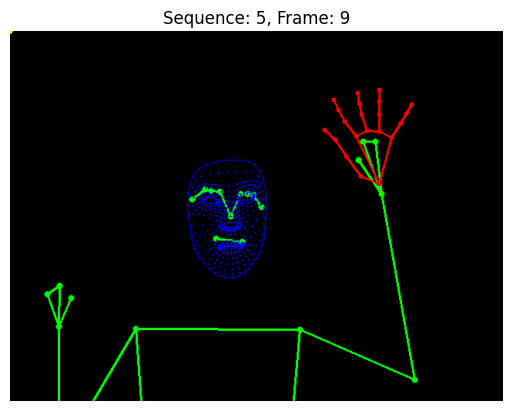

KeyboardInterrupt: 

In [76]:
play_collected_frames_for_action_inline_with_lines('doctor', DATA_PATH='MY_DATA', fps=10, sequence=None)

In [127]:
def play_original_frames_inline(action, DATA_PATH='MY_DATA', fps=60, sequence=None):
    """
    Play original collected frames for all sequences of a given action inline in a notebook.
    If a specific sequence is provided via the 'sequence' parameter, only that folder will be played.
    Otherwise, all subfolders in DATA_PATH/action are processed.

    Assumes the original frames have been saved as image files (.jpg or .png).
    """
    # Define the expected canvas dimensions for display
    width, height = 640, 480

    action_folder = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_folder):
        print(f"Action folder '{action_folder}' does not exist.")
        return

    # Determine which sequence(s) to process
    if sequence is not None:
        seq_path = os.path.join(action_folder, sequence)
        if os.path.isdir(seq_path):
            sequence_folders = [sequence]
        else:
            print(f"Sequence folder '{sequence}' not found in '{action_folder}'.")
            return
    else:
        # Get all subfolders within the action folder
        sequence_folders = [
            d for d in os.listdir(action_folder)
            if os.path.isdir(os.path.join(action_folder, d))
        ]
        sequence_folders.sort()

    if not sequence_folders:
        print(f"No sequence subfolders found in '{action_folder}'.")
        return

    # Iterate over each sequence subfolder
    for sequence_name in sequence_folders:
        seq_folder = os.path.join(action_folder, sequence_name)

        # Look for image files (original frames)
        image_files = sorted(
            [f for f in os.listdir(seq_folder) if f.lower().endswith(('.jpg', '.png'))],
            key=lambda x: int(os.path.splitext(x)[0])  # Assumes filenames like "0.jpg", "1.jpg", etc.
        )
        if not image_files:
            print(f"  No image files found in '{seq_folder}'. Skipping.")
            continue

        frames = []
        for image_file in image_files:
            file_path = os.path.join(seq_folder, image_file)
            frame = cv2.imread(file_path)
            if frame is None:
                continue
            # Convert from BGR to RGB for correct inline display
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        # Display each frame inline as a video using matplotlib
        plt.figure(figsize=(width/100, height/100))
        for frame_idx, frame in enumerate(frames):
            plt.imshow(frame)
            plt.title(action)
            plt.axis('off')
            plt.draw()
            plt.pause(1.0 / fps)  # Pause based on fps
            clear_output(wait=True)
        plt.close()

In [134]:
# This will play all sequences for the given action using the original frames.
play_original_frames_inline(action='DEAF', DATA_PATH='MP_Data')

  No image files found in 'MP_Data/DEAF/0'. Skipping.
  No image files found in 'MP_Data/DEAF/1'. Skipping.
  No image files found in 'MP_Data/DEAF/11'. Skipping.
  No image files found in 'MP_Data/DEAF/12'. Skipping.
  No image files found in 'MP_Data/DEAF/14'. Skipping.
  No image files found in 'MP_Data/DEAF/15'. Skipping.
  No image files found in 'MP_Data/DEAF/16'. Skipping.
  No image files found in 'MP_Data/DEAF/17'. Skipping.
  No image files found in 'MP_Data/DEAF/18'. Skipping.
  No image files found in 'MP_Data/DEAF/19'. Skipping.
  No image files found in 'MP_Data/DEAF/2'. Skipping.
  No image files found in 'MP_Data/DEAF/20'. Skipping.
  No image files found in 'MP_Data/DEAF/3'. Skipping.
  No image files found in 'MP_Data/DEAF/4'. Skipping.
  No image files found in 'MP_Data/DEAF/5'. Skipping.
  No image files found in 'MP_Data/DEAF/6'. Skipping.
  No image files found in 'MP_Data/DEAF/7'. Skipping.
  No image files found in 'MP_Data/DEAF/8'. Skipping.
  No image files fo

In [90]:
%pip install openai==0.28.0

Found existing installation: openai 0.28.0
Uninstalling openai-0.28.0:
  Would remove:
    /Users/wincedelafuente/Documents/ActionDetectionforSignLanguage/myenv/bin/openai
    /Users/wincedelafuente/Documents/ActionDetectionforSignLanguage/myenv/lib/python3.12/site-packages/openai-0.28.0.dist-info/*
    /Users/wincedelafuente/Documents/ActionDetectionforSignLanguage/myenv/lib/python3.12/site-packages/openai/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import openai
from dotenv import load_dotenv

In [18]:
load_dotenv()

def generate_sentence_from_words_gpt4(detected_words, openai_api_key):
    openai.api_key = openai_api_key
    gloss = " ".join(detected_words)
    prompt = (
        "You are an expert translator specializing in translating English grammar into Filipino Sign Language (FSL) gloss notation. "
        "Given an English sentence, provide exactly one accurate Filipino Sign Language gloss translation, structured according to the grammatical rules of FSL. "
        "Return only a sequence of English words separated by a single space, with no additional punctuation or symbols. "
        f"English Input:\n{gloss}\n\n"
        "Filipino Sign Language Gloss Translation:"
    )
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert translator."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=20,
        n=1,
        stop=["\n"]
    )
    translation = response["choices"][0]["message"]["content"].strip()
    return translation

## 7. Running FSL To English GPT Model

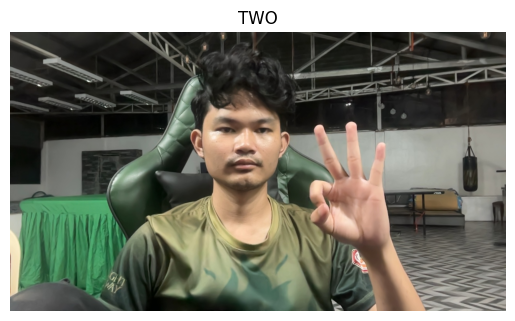

In [120]:
# Call the function and print the output.
openai_api_key = os.getenv('OPENAI_API_KEY')
# Dummy data with proper English grammar:
detected_words = ["hello", "two"]

# Call the function with the dummy data:
generated_sentence = generate_sentence_from_words_gpt4(detected_words, openai_api_key)
words = generated_sentence.split()
for word in words:
    # Here, each 'word' is used as the folder name (and caption) in DATA_PATH.
    play_original_frames_inline(word, DATA_PATH='MY_DATA', fps=30)